In [ ]:
import pandas as pd
data1 = pd.read_excel('/content/drive/MyDrive/MS Thesis/PPase_protSubtrates_201903.xls')
data1 = data1.iloc[:, [1, 3]]
data2 = pd.read_excel('/content/drive/MyDrive/MS Thesis/Connection1/connection104.xlsx')
data2 = data2.iloc[:, [2, 3]]
data2.rename(columns={'Gene Name': 'Phosphatase entry names'}, inplace=True)
dataset = pd.merge(data1, data2, on='Phosphatase entry names', how='outer')
print(dataset)

      Phosphatase entry names Substrate entry names  \
0                      10-LAH                   NaN   
1                        12AH                   NaN   
2                          1a                   NaN   
3                       1a-1b                   NaN   
4                       1a-1b                   NaN   
...                       ...                   ...   
43401                     NaN                   NaN   
43402                     NaN                   NaN   
43403                     NaN                   NaN   
43404                     NaN                   NaN   
43405                     NaN                   NaN   

                                           Disease Entry  
0                                        Discovery agent  
1                                        Discovery agent  
2                                        Discovery agent  
3                    Coronavirus Disease 2019 (COVID-19)  
4      Middle East Respiratory Syndrome (MER

In [ ]:
dataset = dataset.drop_duplicates()
dataset = dataset.dropna()
dataset = dataset[dataset['Disease Entry'] != 'Discovery agent']
print(dataset)
dataset.to_csv('SP.csv', index=False)

      Phosphatase entry names Substrate entry names  \
512                      ACP4                 ERBB4   
513                      ACP5                  ARSA   
516                      ACPP                 ERBB2   
2118                     ALPL             HIST1H2AG   
2119                     ALPL             HIST1H2AG   
...                       ...                   ...   
35538                   PTPRC                   CSK   
35586                   PTPRS                  EGFR   
35588                   PTPRS                 NTRK1   
35590                   PTPRS                 NTRK3   
35592                   PTPRS                 NTRK2   

                                           Disease Entry  
512                                        Acne vulgaris  
513                                        Acne vulgaris  
516                                      Prostate cancer  
2118                                    Neuropathic pain  
2119                   Parasitic infection; 

In [ ]:

# Create a DataFrame
df = pd.DataFrame(dataset)

# Group by 'Phosphatase entry names' and 'Substrate entry names' and concatenate the diseases
combined_diseases = df.groupby(['Phosphatase entry names', 'Substrate entry names'])['Disease Entry'].apply(lambda x: '; '.join(x.unique())).reset_index()

# Display the result
print(combined_diseases)


    Phosphatase entry names Substrate entry names  \
0                      ACP4                 ERBB4   
1                      ACP5                  ARSA   
2                      ACPP                 ERBB2   
3                      ALPL                   BAD   
4                      ALPL             HIST1H2AG   
..                      ...                   ...   
216                   PTPRC                  TYK2   
217                   PTPRS                  EGFR   
218                   PTPRS                 NTRK1   
219                   PTPRS                 NTRK2   
220                   PTPRS                 NTRK3   

                                         Disease Entry  
0                                        Acne vulgaris  
1                                        Acne vulgaris  
2                                      Prostate cancer  
3    Neuropathic pain; Parasitic infection; Colon c...  
4    Neuropathic pain; Parasitic infection; Colon c...  
..                   

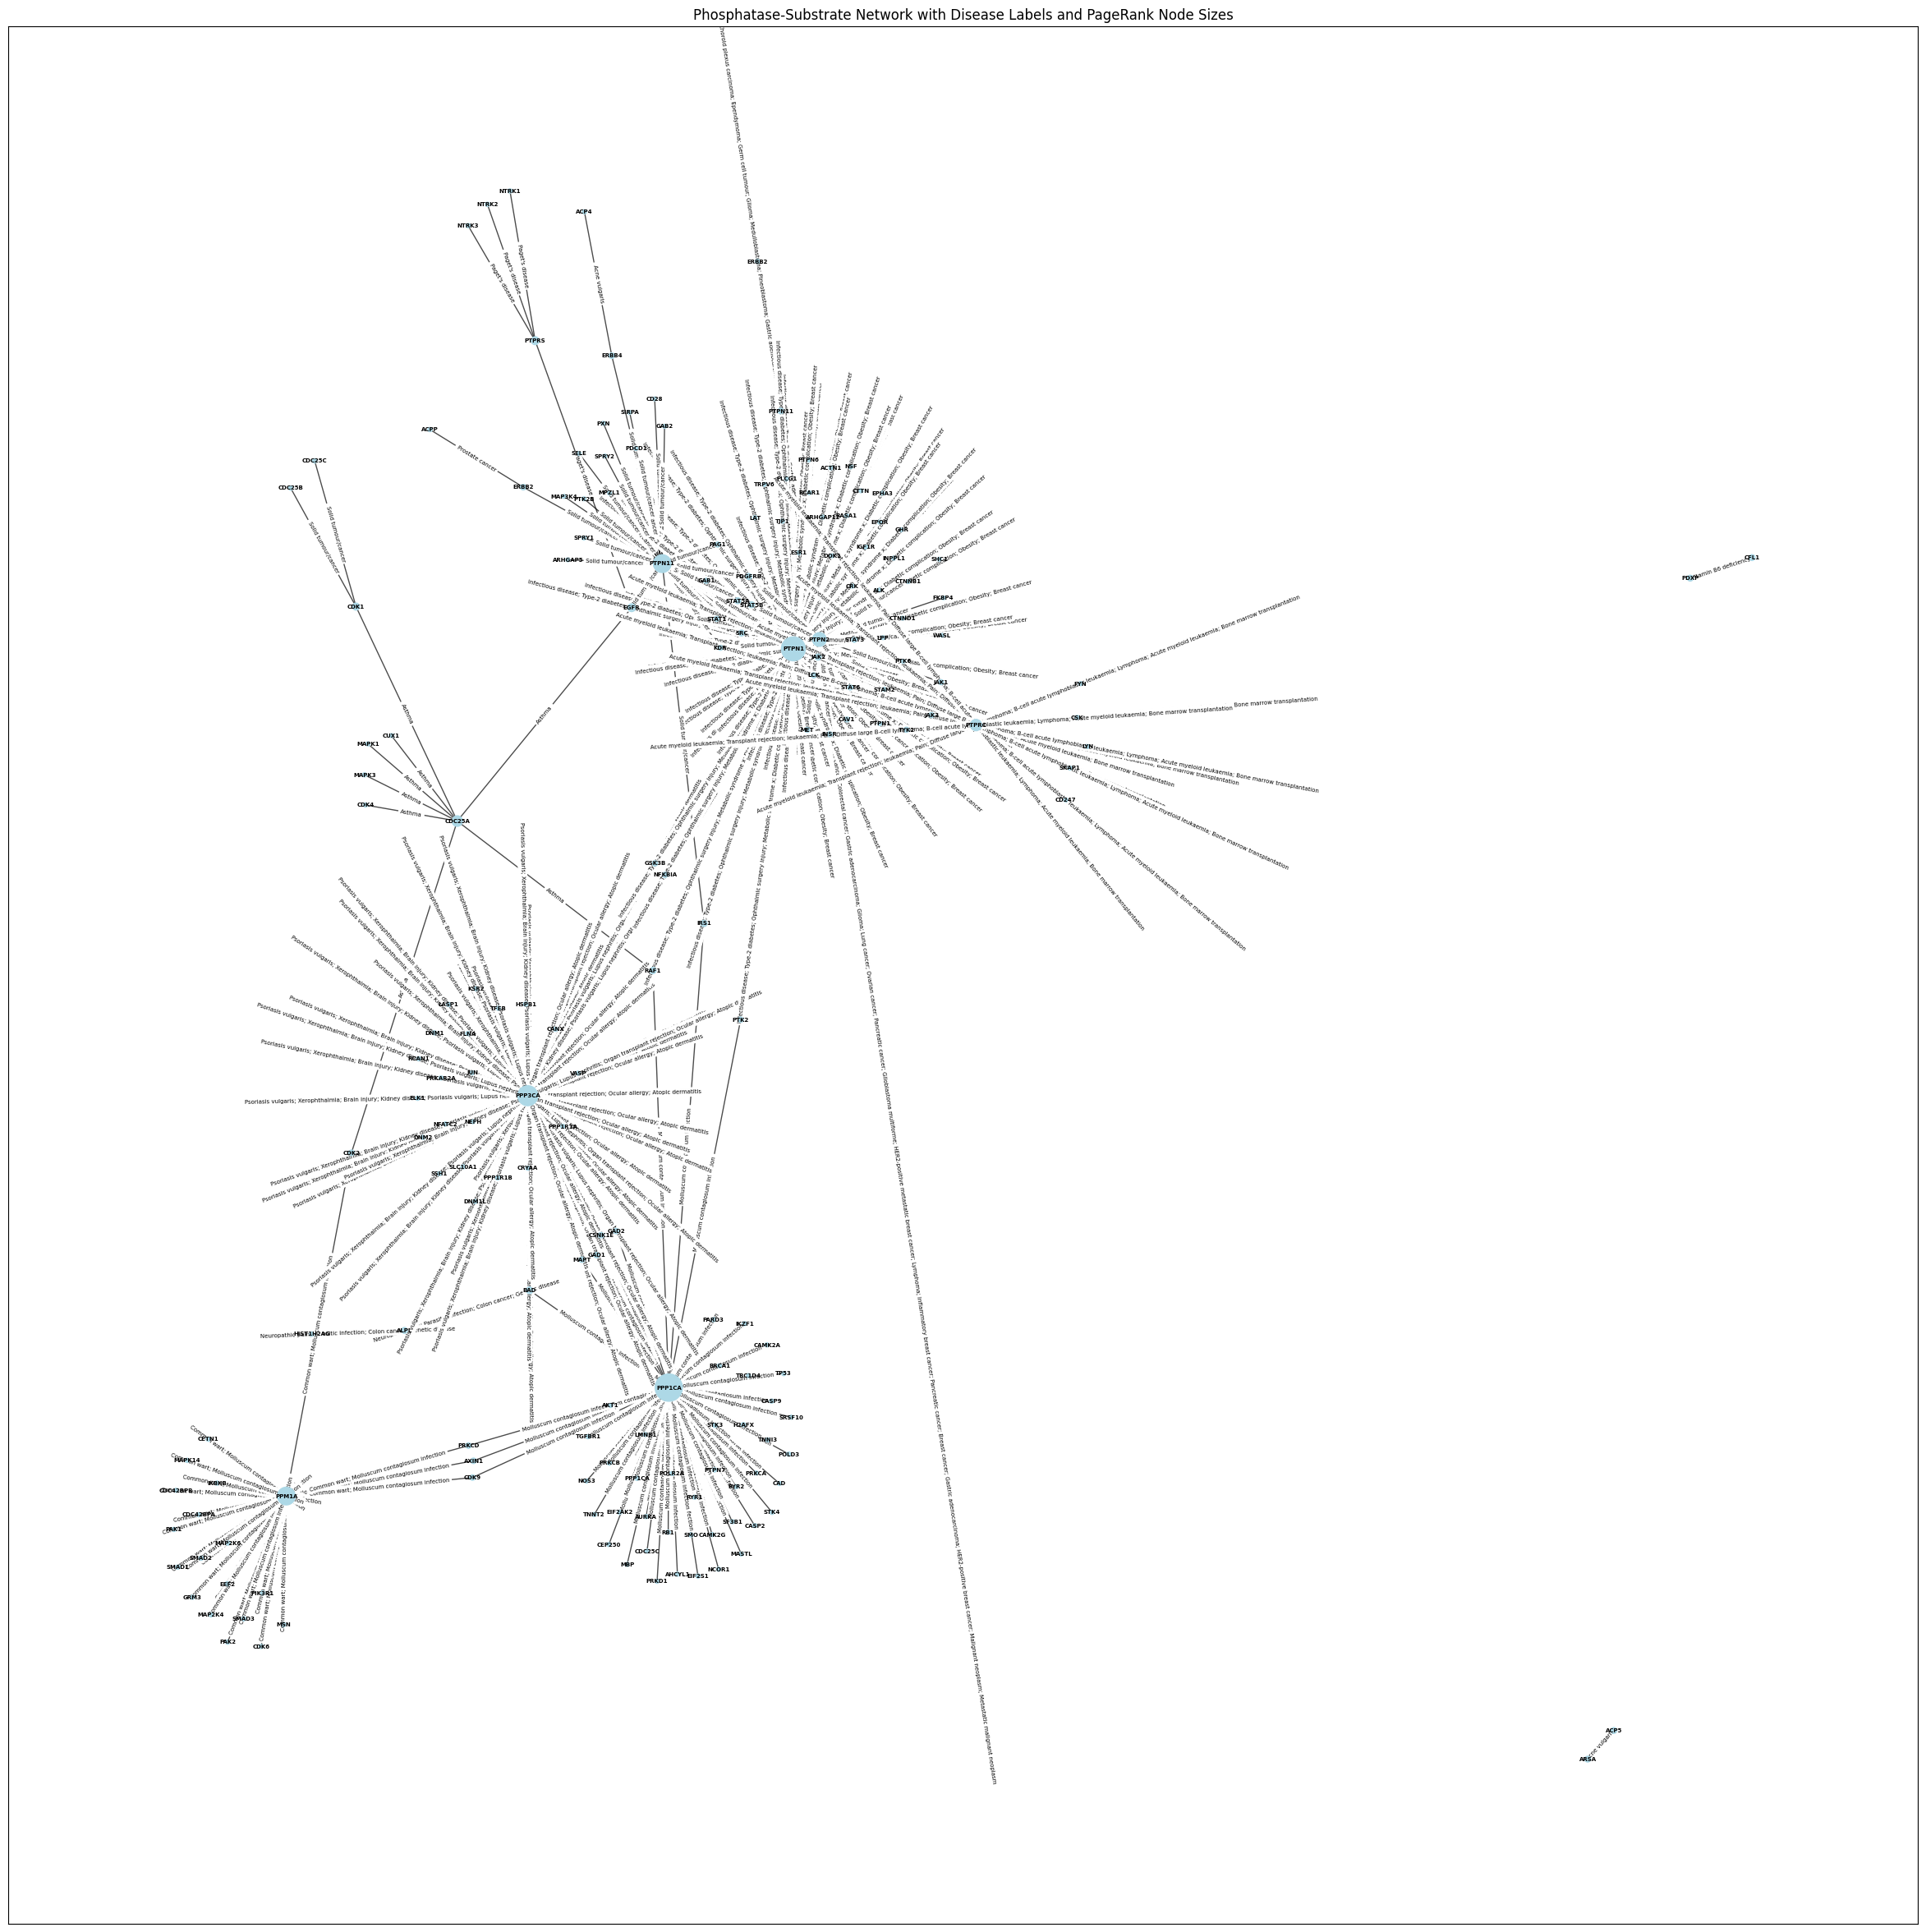

Average degree: 2.3386243386243386
Size of largest connected component: 185


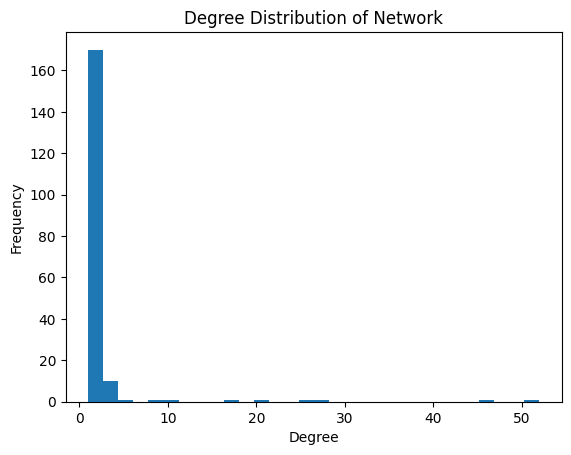

Top 10 nodes by PageRank score:
Node 10: 0.1142984571314001
Node 12: 0.08792610383878627
Node 11: 0.061630307039096714
Node 13: 0.04861545955624749
Node 9: 0.04840559086547939
Node 14: 0.02914719040737397
Node 15: 0.01968583583725202
Node 4: 0.017079499644242924
Node 16: 0.009608577119311004
Node 26: 0.009323320069103896


In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset (combined_diseases should already be created from the previous steps)
data = combined_diseases

# Generate unique nodes for phosphatase and substrate
phosphatase_nodes = list(data['Phosphatase entry names'].unique())
substrate_nodes = list(data['Substrate entry names'].unique())

# Map phosphatases and substrates to numeric ids
phosphatase_dict = {node: idx for idx, node in enumerate(phosphatase_nodes)}
substrate_dict = {node: len(phosphatase_nodes) + idx for idx, node in enumerate(substrate_nodes)}

# Initialize an empty graph
G = nx.Graph()

# Add nodes to the graph
for node in phosphatase_nodes:
    G.add_node(phosphatase_dict[node], label=node, type="Phosphatase")
for node in substrate_nodes:
    G.add_node(substrate_dict[node], label=node, type="Substrate")

# Add edges based on the disease information
disease_edges = {}

for _, row in data.iterrows():
    phosphatase_id = phosphatase_dict[row['Phosphatase entry names']]
    substrate_id = substrate_dict[row['Substrate entry names']]
    disease = row['Disease Entry']

    # Create a unique edge key (phosphatase, substrate)
    edge = (min(phosphatase_id, substrate_id), max(phosphatase_id, substrate_id))

    # If the edge already exists, concatenate the new disease to the existing list
    if edge in disease_edges:
        disease_edges[edge].append(disease)
    else:
        disease_edges[edge] = [disease]

# Add only edges with disease information (no disease = no edge)
for edge, diseases in disease_edges.items():
    if diseases:  # Only add the edge if there are diseases associated with it
        phosphatase_id, substrate_id = edge
        disease_str = ', '.join(diseases)  # Concatenate all diseases
        G.add_edge(phosphatase_id, substrate_id, disease=disease_str)

# Apply the PageRank algorithm to the graph
pagerank = nx.pagerank(G, alpha=0.85)  # Default alpha=0.85 (damping factor)

# Visualize the network
plt.figure(figsize=(30, 30))
pos = nx.spring_layout(G, seed=42)  # Position the nodes using spring layout

# Draw the nodes with size proportional to their PageRank score
node_size = [5000 * pagerank[node] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='lightblue')

# Draw the edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7)

# Draw node labels (phosphatase and substrate names)
node_labels = {node: G.nodes[node]['label'] for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=5, font_weight='bold')

# Draw edge labels (concatenated disease names on edges)
edge_labels = nx.get_edge_attributes(G, 'disease')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=5)

plt.title("Phosphatase-Substrate Network with Disease Labels and PageRank Node Sizes")
plt.show()

# Basic analysis: Degree distribution
degree_sequence = [d for n, d in G.degree()]
print(f"Average degree: {sum(degree_sequence) / len(degree_sequence)}")

# Find and analyze the largest connected component (LCC)
lcc = max(nx.connected_components(G), key=len)
print(f"Size of largest connected component: {len(lcc)}")

# Degree distribution plot
plt.hist(degree_sequence, bins=30)
plt.title("Degree Distribution of Network")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

# Output the top 10 nodes based on PageRank scores
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)
print("Top 10 nodes by PageRank score:")
for node, score in sorted_pagerank[:10]:
    print(f"Node {node}: {score}")


In [ ]:
!pip install hmmlearn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 6.3 MB/s eta 0:00:00


In [ ]:
!pip install pgmpy


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Count the frequency of each disease
disease_counts = dataset['Disease Entry'].value_counts()

# Step 2: Calculate the probability of each disease
total_records = len(dataset)
disease_probabilities = disease_counts / total_records

# Step 3: Create the disease-to-edge probability mapping
disease_to_edge_prob = disease_probabilities.to_dict()

# Print the disease-to-edge probability mapping
print("Disease to Edge Probability Mapping:")
for disease, prob in disease_to_edge_prob.items():
    print(f"{disease}: {prob:.4f}")

# Step 4: Create a list of unique phosphatases and substrates
phosphatases = dataset['Phosphatase entry names'].unique()
substrates = dataset['Substrate entry names'].unique()

# Step 5: Initialize a matrix for disease-to-edge probability mapping
probability_matrix = pd.DataFrame(np.zeros((len(phosphatases), len(substrates))),
                                  index=phosphatases, columns=substrates)

# Step 6: Fill the matrix with the corresponding disease probability
for index, row in dataset.iterrows():
    phosphatase = row['Phosphatase entry names']
    substrate = row['Substrate entry names']
    disease = row['Disease Entry']

    # Get the probability for the disease
    min_prob = disease_probabilities.min()
    prob = disease_to_edge_prob.get(disease, min_prob)


    # Assign the probability to the matrix at the corresponding phosphatase and substrate
    probability_matrix.loc[phosphatase, substrate] = prob

# Step 7: Display the probability matrix as a colorful table
# Apply color gradient to the matrix
styled_matrix = probability_matrix.style.background_gradient(cmap='YlGnBu', axis=None)

# Display the styled table
styled_matrix


Disease to Edge Probability Mapping:
Molluscum contagiosum infection: 0.0837
Solid tumour/cancer: 0.0741
Infectious disease: 0.0741
Type-2 diabetes: 0.0741
Ophthalmic surgery injury: 0.0741
Metabolic syndrome x: 0.0741
Diabetic complication: 0.0741
Obesity; Breast cancer: 0.0741
Atopic dermatitis: 0.0451
Organ transplant rejection; Ocular allergy: 0.0451
Kidney disease; Psoriasis vulgaris; Lupus nephritis: 0.0451
Psoriasis vulgaris; Xerophthalmia; Brain injury: 0.0451
Common wart; Molluscum contagiosum infection: 0.0338
Lymphoma: 0.0177
leukaemia: 0.0161
Transplant rejection: 0.0161
Acute myeloid leukaemia: 0.0161
Pain: 0.0161
Diffuse large B-cell lymphoma; B-cell acute lymphoblastic leukaemia: 0.0161
Acute myeloid leukaemia; Bone marrow transplantation: 0.0161
Asthma: 0.0129
Paget's disease: 0.0064
Prostate cancer: 0.0032
Acne vulgaris: 0.0032
Neuropathic pain: 0.0032
Parasitic infection; Colon cancer: 0.0032
Genetic disease: 0.0032
HER2-positive metastatic breast cancer: 0.0016
Pancr

https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Predicted Disease for Phosphatase PtpA and Substrate P1: Acute myeloid leukaemia; Transplant rejection; leukaemia; Pain; Diffuse large B-cell lymphoma; B-cell acute lymphoblastic leukaemia; Lymphoma; Acute myeloid leukaemia; Bone marrow transplantation


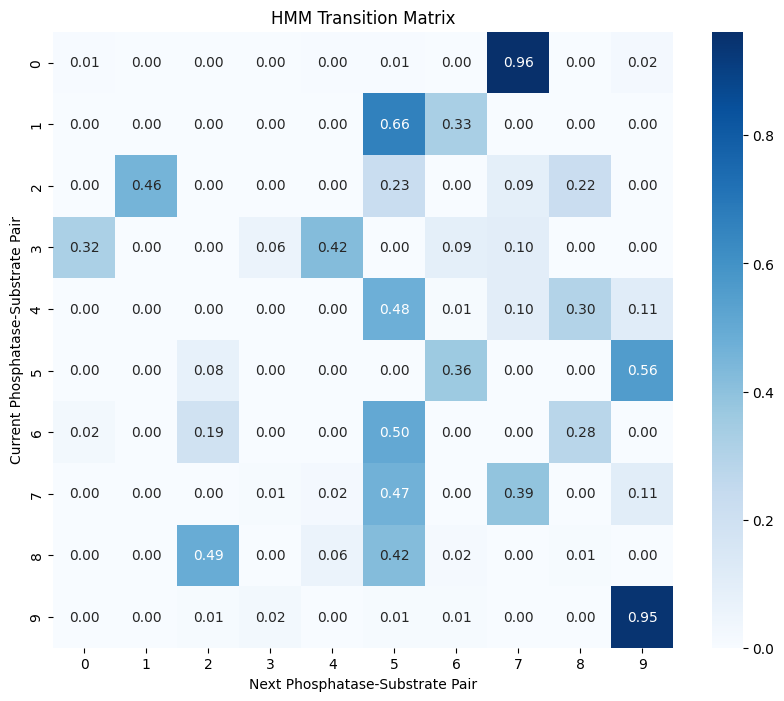

In [ ]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
import random

dataset = combined_diseases

# Step 1: Prepare the dataset (Phosphatase-Substrate pairs as states, Disease as edges)
dataset['Phosphatase-Substrate'] = (
    dataset['Phosphatase entry names'].astype(str) + "-" +
    dataset['Substrate entry names'].astype(str)
)

# Step 2: Create the state transition sequences based on Phosphatase-Substrate pairs
sequences = dataset['Phosphatase-Substrate'].values

# Map states to numeric values for HMM (encode each unique state)
state_mapping = {state: idx for idx, state in enumerate(set(sequences))}
encoded_sequences = [state_mapping[state] for state in sequences]

# Reshape sequences to fit the HMM model input format
X = np.array(encoded_sequences).reshape(-1, 1)

# Step 3: Define the HMM model (e.g., using 10 hidden states or more, depending on the complexity)
model = hmm.MultinomialHMM(n_components=10, random_state=42)

# Step 4: Fit the model to the data
model.fit(X)

# Step 5: Predict the hidden states based on the sequence of observations
hidden_states = model.predict(X)

# Step 6: Transition Matrix and Disease Prediction (Finding Connections via Disease)
transition_matrix = model.transmat_

# Define a function to predict the disease based on phosphatase-substrate interaction
def predict_disease_from_edge(phosphatase, substrate):
    state = f"{phosphatase}-{substrate}"
    if state in state_mapping:
        state_idx = state_mapping[state]
        predicted_state = np.argmax(transition_matrix[state_idx])  # Find next likely state
        # Get the corresponding Disease Entry for the predicted state
        predicted_disease = list(state_mapping.keys())[predicted_state]
        return predicted_disease.split("-")[2]  # Extract the disease part
    else:
        return random.choice(dataset['Disease Entry'].unique())  # Random disease if no transition found

# Example Prediction:
phosphatase = 'PtpA'
substrate = 'P1'
predicted_disease = predict_disease_from_edge(phosphatase, substrate)
print(f"Predicted Disease for Phosphatase {phosphatase} and Substrate {substrate}: {predicted_disease}")

# Step 7: Plot the Transition Matrix (Heatmap)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title("HMM Transition Matrix")
plt.xlabel("Next Phosphatase-Substrate Pair")
plt.ylabel("Current Phosphatase-Substrate Pair")
plt.show()
